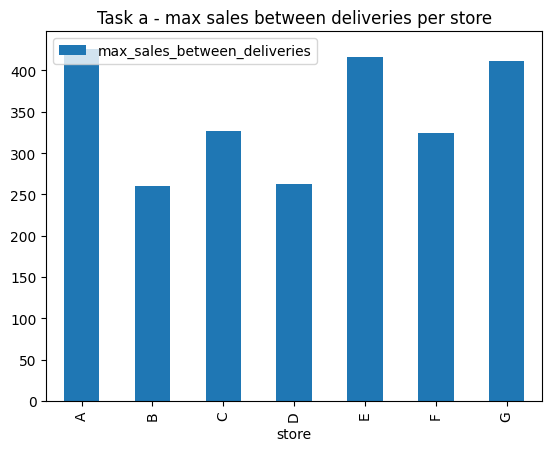

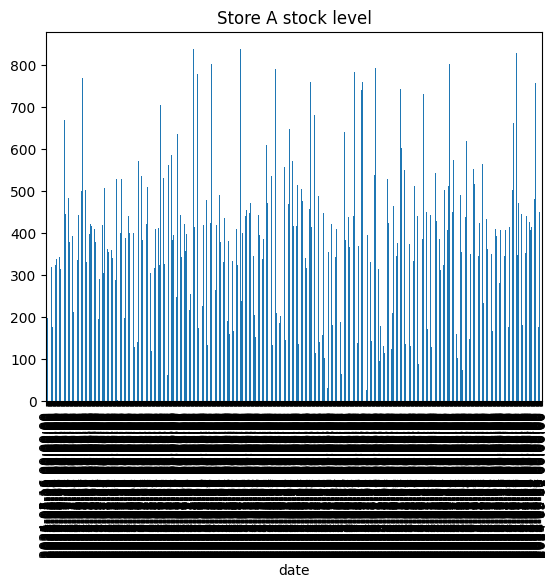

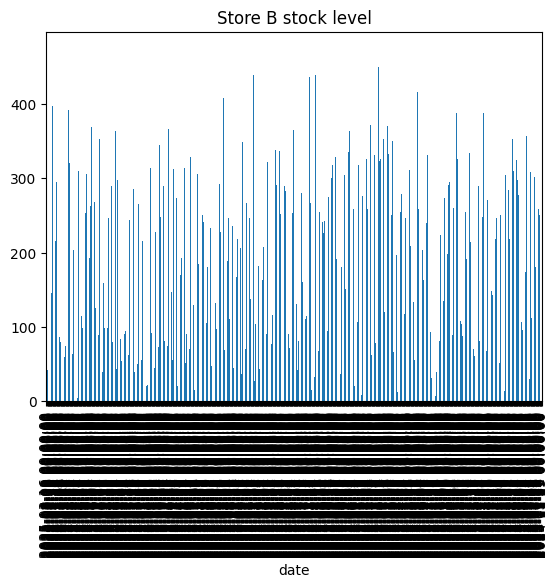

In [ ]:
import sqlite3
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

from common.db import get_db_connection

TITLE = "Task a - max sales between deliveries per store"

DELIVERY_SIZE = 100
STORES_URL = "https://docs.google.com/spreadsheets/d/e/2PACX-1vREq5BAnlzZL1X0v3PThJI7HtzoCup6Y14X-JC1o0LERTHqYE3rYmMzOBoTHo9FvKLHNat1tjhNDEjr/pub?gid=1671734850&single=true&output=csv"
STOCK_LEVELS = "stock_levels"

stores_level_stock = pd.read_csv(STORES_URL)

create_stock_level_table_query = f"""
CREATE TABLE IF NOT EXISTS {STOCK_LEVELS}(
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            store VARCHAR(10),
            date VARCHAR(10),
            opening_stock INTEGER);"""

max_sales_per_store_query = f"""WITH base AS (SELECT store,
                     substr(date, 7) || substr(date, 4, 2) || substr(date, 1, 2) as date_str,
                     opening_stock                                               as stock_level
              FROM {STOCK_LEVELS}
              GROUP BY store, date_str
              order by store, date_str),

     deliveries_table AS (SELECT store,
                                 date_str,
                                 stock_level -
                                 lag(stock_level) OVER (PARTITION BY store ORDER BY store, date_str) as change,
                                 CASE
                                     WHEN stock_level -
                                          lag(stock_level) OVER (PARTITION BY store ORDER BY store, date_str) > 0
                                         THEN {DELIVERY_SIZE}
                                     ELSE 0 end                                                      as deliveries
                          from base
                          order by store, date_str),

     sales_table AS (SELECT store,
                            date_str,
                            deliveries,
                            CASE
                                WHEN change < 0 THEN ABS(change)
                                WHEN change > 0 THEN ABS(deliveries - change)
                                ELSE 0 end as sales
                     from deliveries_table),
     delivery_numer_table as (SELECT store,
                                     date_str,
                                     ROW_NUMBER() OVER (PARTITION BY store ) as delivery_number,
                                     LEAD(date_str) OVER ()                  as end_date
                              FROM sales_table
                              where deliveries > 0
                              order by store, date_str),

     sales_cum_sum_table as (SELECT sum(ot.sales)
                                        OVER (PARTITION BY ot.store, dnt.delivery_number ORDER BY ot.store, ot.date_str) as sales_cum_sum,
                                    ot.store,
                                    ot.date_str,
                                    dnt.delivery_number,
                                    end_date
                             FROM sales_table ot
                                      LEFT JOIN delivery_numer_table dnt
                                                on ot.store = dnt.store AND ot.date_str < dnt.end_date and
                                                   ot.date_str >= dnt.date_str
                             WHERE dnt.delivery_number > 0
                             order by ot.store, ot.date_str)
SELECT store,
       max(sales_cum_sum) as max_sales_between_deliveries,
       date_str           as start_period,
       end_date           as end_period
from sales_cum_sum_table
GROUP BY store
"""


def get_db_connection(db_name: str):
    file = f'{db_name}.db'
    Path(file).touch()
    con = sqlite3.connect(file)
    con.row_factory = sqlite3.Row
    return con


def load_result_df():
    with get_db_connection(db_name=STOCK_LEVELS) as con:
        cursor = con.cursor()
        cursor.execute(create_stock_level_table_query)
        stores_level_stock.to_sql(STOCK_LEVELS, con, if_exists="replace")
        max_sales_per_stores = cursor.execute(max_sales_per_store_query).fetchall()
        con.commit()
    return pd.DataFrame([{k: inspect[k] for k in inspect.keys()} for inspect in max_sales_per_stores])


def task_a():
    max_sales_per_store_df = load_result_df()
    df_plot = max_sales_per_store_df[["store", "max_sales_between_deliveries"]] \
        .set_index("store") \
        .plot \
        .bar(title=TITLE)
    plt.show()
    return df_plot


def task_b():
    return load_result_df()


def task_c():
    for name, group in stores_level_stock.groupby('store'):
        group.index = pd.to_datetime(group["date"])
        group["opening_stock"].plot.bar(title=f"Store {name} stock level")
        plt.show()

task_a()
task_b()
task_c()